## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import pickle
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Utility functions

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

In [4]:
def heuristic_trajectory(pos, center, num_actions, img_st, hasfire, control):
    trajectory = []
    actions = []
    trajectory.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    
    if hasfire:
        fires_r, fires_c = np.where(img_st==1)
        neighbors = [(-1,0),(1,0),(0,1),(0,-1)]
        fire = []
        bdry = []
        for r,c in zip(fires_r,fires_c):
            counter = 0
            for (dr,dc) in neighbors:
                rn = r + dr
                cn = c + dc
                if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] == 0:
                    counter += 1
                    
            x = col_to_x(c) - img_dim//2 + pos[0]
            y = row_to_y(img_dim,r) - img_dim//2 + pos[1]
            if counter >= 2 and (x,y) not in control:
                bdry.append((x,y))
            elif (x,y) not in control:
                fire.append((x,y))
                
        target = None
        using_bdry = False
        if len(bdry) > 0:
            dists = [(np.abs(x-pos[0])+np.abs(y-pos[1]),(x,y)) for (x,y) in bdry]
            using_bdry = True
            target = min(dists)[1]
        elif len(fire) > 0:
            dists = [(np.abs(x-pos[0])+np.abs(y-pos[1]),(x,y)) for (x,y) in fire]
            target = min(dists)[1]
        else:
            target = trajectory[-1]
    
        while len(trajectory) < num_actions+1:
            loc = trajectory[-1]
            if loc == target:
                if using_bdry:
                    bdry.remove(target)
                elif len(fire) > 0:
                    fire.remove(target)
                    
                target = None
                using_bdry = False
                if len(bdry) > 0:
                    dists = [(np.abs(x-loc[0])+np.abs(y-loc[1]),(x,y)) for (x,y) in bdry]
                    target = min(dists)[1]
                    using_bdry = True
                elif len(fire) > 0:
                    dists = [(np.abs(x-loc[0])+np.abs(y-loc[1]),(x,y)) for (x,y) in fire]
                    target = min(dists)[1]
                else:
                    target = trajectory[-1]
                    
            dists = []
            for a in range(9):
                new_loc = actions_to_trajectory(trajectory[-1],[a])[1]
                dists.append((np.abs(new_loc[0]-target[0])+np.abs(new_loc[1]-target[1]),new_loc,a))
                
            trajectory.append(min(dists)[1])
            actions.append(min(dists)[2])
            #print(trajectory)
        
    else:
        for k in range(num_actions):
            dists = []
            for a in range(9):
                new_loc = actions_to_trajectory(trajectory[-1],[a])[1]
                dists.append((np.abs(center-new_loc[0])+np.abs(center-new_loc[1]),new_loc,a))
            
            trajectory.append(min(dists)[1])
            actions.append(min(dists)[2])
            
    return trajectory, actions

## Load data

In [5]:
# directory = os.path.join(os.getcwd(), 'data')

# pattern = os.path.join(directory,'states_seed_*')

# data = {}
# k = 0
# total_states = 0
# for file in glob.glob(pattern):
#     fh = open(file, 'rb')
#     sub_data = pickle.load(fh)
#     data[k] = sub_data
#     fh.close()
#     k += 1
#     total_states += sub_data.shape[0]
    
# print('loaded %d sims from file' %(k))
# print('for a total of %d states' %(total_states))

## Network datatype [cpu/gpu]

In [6]:
torch.cuda.is_available()

True

In [7]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

## Build the network

In [8]:
class eelfff_net(nn.Module):
    """
    network to approximate Q function
    """
    def __init__(self, act_seq=6, img_dim=8):
        self.act_seq = act_seq
        self.img_dim = img_dim
        self.num_poss_actions = 9
        
        C, H, W = 1, img_dim, img_dim
        hidden_dim = 1024
        
        # conv layer settings
        nf1 = 32; nf2 = 64; nf3 = 64;
        fs1 = 4; fs2 = 3; fs3 = 2;
        cv_s1 = 1; cv_s2 = 1; cv_s3 = 1;
        cv_p1 = 0; cv_p2 = 0; cv_p3 = 0;
        
        # pool layer settings
        #p_sz1 = 4; p_sz2 = 2
        #p_st1 = 1; p_st2 = 1
        
        # calculate affine layer size
        Hp1 = 1 + (H + 2*cv_p1 - fs1) // cv_s1
        Wp1 = Hp1
        #Hpp1 = 1 + (Hp1 - p_sz1) // p_st1
        #Wpp1 = Hpp1
        
        Hp2 = 1 + (Hp1 + 2*cv_p2 - fs2) // cv_s2
        Wp2 = Hp2
        #Hpp2 = 1 + (Hp2 - p_sz2) // p_st2
        #Wpp2 = Hpp2
        
        Hp3 = 1 + (Hp2 + 2*cv_p3 - fs3) // cv_s3
        Wp3 = Hp3        
        
        #aff_flat_size = nf2*Hpp2*Wpp2 + 2*act_seq
        # image + other trajectory + center + has fire 
        aff_flat_size = nf3*Hp3*Wp3 + 2*(act_seq+1) + 2 + 1
        
        #print(Hp1)
        #print(Hp2)
        #print(Hp3)
        
        super(eelfff_net, self).__init__()
        # cnn structure
        self.cnn = nn.Sequential(
                        nn.Conv2d(C, nf1, kernel_size=fs1, stride=cv_s1, padding=cv_p1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf2, nf3, kernel_size=fs3, stride=cv_s3, padding=cv_p3),
                        nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz1,stride=p_st1),
                        #nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        #nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz2,stride=p_st2),
                        Flatten()
                    )
        
        # nonlinear structure
        self.aff = nn.Sequential(
                        nn.Linear(aff_flat_size, hidden_dim),
                        nn.ReLU(inplace=True),
                        #nn.Linear(hidden_dim, self.num_poss_actions*act_seq),
                        nn.Linear(hidden_dim, self.num_poss_actions)
                    )
        
    def forward(self, img, act, center, hasfire):
        img_exp = img.unsqueeze(0)
        img_exp = img_exp.unsqueeze(0)
        act_exp = act.unsqueeze(0)
        cen_exp = center.unsqueeze(0)
        hsf_exp = hasfire.unsqueeze(0)
        feat = self.cnn(img_exp)
        feat = torch.cat((feat, act_exp, cen_exp, hsf_exp), dim=1)
        Q = self.aff(feat)
        
        #return Q.view(N,self.num_poss_actions,self.act_seq)
        return Q.view(N,self.num_poss_actions,-1)

test implementation of network with random data

In [9]:
tic = time.clock()
N = 1
img_dim = 8
act_seq = 3
model = eelfff_net(act_seq, img_dim).type(dtype)

img = torch.randn(img_dim,img_dim).type(dtype)
act = torch.randn(2*(act_seq+1)).type(dtype)
center = torch.randn(2).type(dtype)
hasfire = (True*torch.ones(1)).type(dtype)

img_var = Variable(img)
act_var = Variable(act)
center_var = Variable(center)
hasfire_var = Variable(hasfire)

Q = model(img_var, act_var, center_var, hasfire_var)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([1, 9, 1])
469.28s = 7.82m elapsed for this test


## Define a reward function

In [10]:
# def eelfff_reward(states, trajs, fire_flags, other_trajs):
#     N = len(states)
#     grid_size = states[0].shape[0]
#     center = math.ceil(grid_size/2)
#     neighbors = [(-1,0),(0,-1),(1,0),(0,1)]
#     #reward = Variable(torch.zeros(1), requires_grad=True).type(dtype)
#     reward = 0
    
#     for n in range(N):
#         st = states[n]
#         traj = trajs[n]
#         other_traj = other_trajs[n]
#         has_fires = fire_flags[n]
#         n_rew = 0
        
#         # reward for treating fires and boundary fires
#         # that weren't already treated by the agent
#         if False and has_fires:
#             treated = []
#             for (x,y) in traj:
#                 r = y_to_row(grid_size,y)
#                 c = x_to_col(x)

#                 # reward for treating a fire
#                 if r>=0 and r<grid_size and c>=0 and c<grid_size and st[r,c]==1 and (x,y) not in treated:
#                     n_rew += 0.1

#                     counter = 0 
#                     for (dc,dr) in neighbors:
#                         rn = r + dr
#                         cn = c + dc
#                         if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and st[rn,cn] == 0:
#                             counter += 1

#                     # bonus for treating a boundary fire
#                     if counter >= 2:
#                         n_rew += 0.1
#                     #    print('treated a boundary fire')
#                     #else:
#                     #    print('treated a normal fire')
                        
#                     treated.append((x,y))
                
#                 #elif (x,y) in treated:
#                 #    n_rew += -3
#                 #
#                 #else:
#                 #    n_rew += -1
#                 else:
#                     n_rew -= 1
           
#         # reward for approaching center [if no fires in image]
#         # else:
#         #x_end, y_end = traj[-1]
#         #n_rew -= np.abs(x_end-center) + np.abs(y_end-center)

#         for k in range(len(traj)-1):
#             x1, y1 = traj[k]
#             x2, y2 = traj[k+1]
#             #if np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
#             #    reward += 1.0/(len(traj)-1)
#             #    #print('made it closer to the center')

#             if np.abs(x2-center)+np.abs(y2-center) >= np.abs(x1-center)+np.abs(y1-center):
#                 n_rew += -1
#             elif np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
#                 n_rew += 0.1
    
#         # penalty for intersecting with 'nearest agent'
#         if not set(traj).isdisjoint(other_traj):
#             #reward += -2*len(set(traj).intersection(other_traj))
#             n_rew -= 1
#             #print('intersected with a friends path :(')
#         else:
#             n_rew += 0.1
            
#         reward += n_rew
    
#     return reward/N

In [11]:
# tic = time.clock()

# states = np.zeros((3,5,5)).astype(np.uint8)
# states[:,2,2] = 1
# trajs = []
# trajs.append([(5,5),(5,5),(4,4)])
# trajs.append([(3,3),(3,3),(3,3)])
# trajs.append([(5,5),(4,4),(3,3)])
# other_trajs = []
# other_trajs.append([(1,1),(1,2),(1,1)])
# other_trajs.append([(1,1),(1,2),(1,3)])
# other_trajs.append([(1,1),(2,2),(3,3)])
# fire_flags = [False, True, True]

# reward = eelfff_reward(states, trajs, fire_flags, other_trajs)
# print('minibatch reward: %0.2f' %reward)

# toc = time.clock()
# print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

In [65]:
def eelfff_reward(state, traj, other_traj, curr_ctrl):
    grid_size = state.shape[0]
    center = math.ceil(grid_size/2)
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(0,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)]
    reward = 0
    
    #print(traj)
    #print(other_traj)
    #print(set(traj).isdisjoint(other_traj))
    #5/0
    
    #for idx, (x,y) in traj:   
    for k in range(len(traj)-1):
        x1, y1 = traj[k]
        x2, y2 = traj[k+1]
        
        near_fire = False
        for (dx,dy) in move_neigh:
            r = y_to_row(grid_size,y1+dy)
            c = x_to_col(x1+dx)
            
            if r>=0 and r<grid_size and c>=0 and c<grid_size and state[r,c]==1:
                near_fire = True
                break
        
        #print(near_fire)
        if near_fire:
            r = y_to_row(grid_size,y2)
            c = x_to_col(x2)
            
            if r>=0 and r<grid_size and c>=0 and c<grid_size and state[r,c]==1 and (x2,y2) not in curr_ctrl:
                counter = 0 
                for (dc,dr) in fire_neigh:
                    rn = r + dr
                    cn = c + dc
                    if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and state[rn,cn]==0:
                        counter += 1
                        
                if counter >= 2:
                    #print('treated boundary')
                    reward += 0.5
                else:
                    #print('treated interior fire')
                    reward += 0.1
                #else:
                #    #print('did not treat boundary fire')
                #    reward -= 1
            else:
                #print('failed to treat fire OR tried to double treat; state value: ', state[r,c])
                reward -= 1
            
        elif np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
            #print('moved closer to center')
            reward += 0.5
        else:
            #if near_fire:
            #    print('failed to treat any fire')
            #else:
            #    print('failed to move closer')
            reward -= 1
            
    # penalty for intersecting with 'nearest agent'
    if not set(traj).isdisjoint(other_traj):
        #reward += -2*len(set(traj).intersection(other_traj))
        #print('failed to cooperate')
        reward = -1
    else:
        reward += 0.5

        
    return reward

test reward function with random data

In [66]:
tic = time.clock()

state = np.zeros((5,5)).astype(np.uint8)
state[2,2] = 1
traj = [(5,5),(4,4),(3,3)]
other_traj = [(1,1),(1,2),(1,1)]
curr_ctrl = []

reward = eelfff_reward(state, traj, other_traj, curr_ctrl)
print('reward: %0.2f' %reward)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

reward: 1.50
0.00s = 0.00m elapsed for this test


## Train the network

In [69]:
# simulator and network parameters
grid_size = 50
num_agents = [2,5,10]
D = []
memory_size = 100000 #1000000
min_exp_size = 10 #100
dp = 0.15/0.2763
act_seq = 1
act_repeat = 6
other_act_seq = act_repeat//2
img_dim = 8
center = math.ceil(grid_size/2)
cen_var = Variable(center*torch.ones(2)).type(dtype)

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

# create network instance
model = eelfff_net(act_seq=other_act_seq, img_dim=img_dim).type(dtype)
target = eelfff_net(act_seq=other_act_seq, img_dim=img_dim).type(dtype)
updt_max = 100 #500
dqn_updt_cntr = 1

# optimizer and its parameters
gamma = 0.95
eps_init = 1
eps_finl = 0.1
epsilon = eps_init #0.15 
anneal_range = 100000 #1000000
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# loss function
loss_fn = torch.nn.MSELoss(size_average=False)

# plotting data
plot_avg_rew = []
plot_frac_burn = []

In [70]:
# img = torch.zeros(img_dim,img_dim)
# act = torch.zeros(2*(act_seq+1))
# empty_img_var = Variable(img).type(dtype)
# empty_traj_var = Variable(act).type(dtype)

optionally load a model/target/optimizer checkpoint

In [71]:
# filename = 'checkpoint-02-Aug-2017-03:26.pth.tar'

# checkpoint = torch.load(filename)
# model.load_state_dict(checkpoint['state_dict'])
# target.load_state_dict(checkpoint['target_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# D = checkpoint['replay']
# epsilon = checkpoint['epsilon']
# plot_avg_rew = checkpoint['plot_reward']
# plot_frac_burn = checkpoint['plot_frac_hlthy'] 

In [74]:
num_agents = [6]
#seeds = range(99)
seeds = [1,1,1,1,1]

In [81]:
tic = time.clock()
# run simulator many times
for s in seeds:
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    
    # initialize agent positions
    n = np.squeeze(np.random.choice(num_agents, 1))
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)
    
    ep_rew = 0
    
    control = []
    repeat_cntr = 1
        
    # run to termination
    while not sim.end:
        
        #control = []
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        agent_data = {}
        #print(agent_pos)
        
        # generate control for each agent
        for k in range(n):
            agent_data[k] = {}
            
            # generate and save image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])
            img_var = Variable(torch.from_numpy(img)).type(dtype)
            hasfire_var = Variable(hasfire*torch.ones(1)).type(dtype)
            agent_data[k]['img'] = img_var
            agent_data[k]['hasfire'] = hasfire_var

            # find nearest neighbor and their trajectory, and save it
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            min_idx = min(dists)[1]
            other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, other_act_seq, other_img_st, other_hasfire, control)
            other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            agent_data[k]['other_traj'] = other_traj_var
            
            # epsilon-greedy action choice: either random/heuristic or use network
            # also generate trajectory
            pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var
            agent_data[k]['pos_cen'] = pos_cen_var
                            
            if np.random.sample() <= epsilon:
                #actions = np.random.randint(0, high=9, size=(act_seq,))
                traj, actions = heuristic_trajectory(agent_pos[k,:], center, act_seq, img_st, hasfire, control)
                actions = np.asarray(actions)
                #print('chose random/heuristic actions')
            else:
                #img_var = empty_img_var
                #other_traj_var = empty_traj_var
                Q = model(img_var, other_traj_var, pos_cen_var, hasfire_var)[0].data.cpu().numpy()
                #print("range of Q values: %f to %f" %(np.amin(Q),np.amax(Q)))
                
                actions = np.argmax(Q,axis=0)
                traj = actions_to_trajectory(agent_pos[k,:], actions)
                
            agent_data[k]['actions'] = actions 
            
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))

            # calculate and store reward for agent
            #reward = eelfff_reward([sim.state], [traj], [hasfire], [other_traj])
            reward = eelfff_reward(sim.state, traj, other_traj, control)
            agent_data[k]['reward'] = reward
            #print(reward)
            ep_rew += reward
                        
            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
            
            #print(other_traj)
            #print(actions)
            #print(traj)
            #5/0
            
        # remove duplicates from control sequence
        control = list(set(control))
        #if control:
        #    print('control is not empty')
        #    print(control)
        #    5/0
        
        # step simulator
        #sim.step(control, dbeta=dp)
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1
                    
        # update agent position
        agent_pos = new_agent_pos
        
        # grab new state information and add to replay memory
        isterminal = False
        for k in range(n):
            # generate and save image
            next_img, _, next_hasfire = CreateImageBW(sim.state, agent_pos[k,:])
            next_img_var = Variable(torch.from_numpy(next_img)).type(dtype)
            next_hasfire_var = Variable(next_hasfire*torch.ones(1)).type(dtype)
            agent_data[k]['next_img'] = next_img_var
            agent_data[k]['next_hasfire'] = next_hasfire_var
            
            # find nearest neighbor and their trajectory
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            min_idx = min(dists)[1]
            other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, other_act_seq, other_img_st, other_hasfire, control)
            other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            agent_data[k]['next_other_traj'] = other_traj_var
            
            next_pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var
            agent_data[k]['next_pos_cen'] = next_pos_cen_var
        
            # check for terminal state
            if sim.end:
                isterminal = True
                
            D.append((agent_data[k]['img'],agent_data[k]['other_traj'],
                      agent_data[k]['pos_cen'],agent_data[k]['hasfire'],
                      agent_data[k]['actions'],agent_data[k]['reward'],
                      agent_data[k]['next_img'],agent_data[k]['next_other_traj'],
                      agent_data[k]['next_pos_cen'],agent_data[k]['next_hasfire'],
                      isterminal))
                
        # create minibatch from replay memory
        loss = 0
        if len(D) < batch_size or len(D) < min_exp_size:
            continue

        batch_idxs = np.random.randint(0,high=len(D),size=batch_size)

        # calculate loss over batch
        # exp indices: 0-img, 1-other_traj, 2-pos_cen, 3-hasfire, 4-actions, 5-reward, 
        #              6-next_img, 7-next_other_traj, 8-next_pos_cen, 9-next_hasfire
        #              10-isterminal
        for idx in batch_idxs:
            exp = D[idx]
            # reward clipping
            #curr_rew = np.clip(exp[5],-5,5)
            curr_rew = exp[5]
            tt = Variable(curr_rew*torch.ones(1),requires_grad=False).type(dtype)
            
            img_var = exp[0]
            other_traj_var = exp[1]
            pos_cen_var = exp[2]
            hasfire_var = exp[3]
            actions = exp[4]
            
            #img_var = empty_img_var
            #other_traj_var = empty_traj_var
            Q = model(img_var, other_traj_var, pos_cen_var, hasfire_var)[0]
            x = Q[torch.from_numpy(actions).type(torch.cuda.LongTensor)].diag().sum()
            #x = Q[torch.from_numpy(actions)].diag().sum()
            
            isterminal = exp[10]
            if not isterminal:
                next_img_var = exp[6]
                next_other_traj_var = exp[7]
                next_pos_cen_var = exp[8]
                next_hasfire_var = exp[9]

                #next_img_var = empty_img_var
                #next_other_traj_var = empty_traj_var
                #Q = model(next_img_var, next_other_traj_var, next_pos_cen_var, next_hasfire_var)[0]
                Q = target(next_img_var, next_other_traj_var, next_pos_cen_var, next_hasfire_var)[0]
                maxQ = Q.max(dim=0)[0].sum()
                #x += gamma*maxQ
                tt += Variable(gamma*maxQ.data, requires_grad=False).type(dtype)
            
            # error clipping
            #loss += (loss_fn(x, tt)).clamp(min=-5,max=5)
            loss += loss_fn(x, tt)

        loss /= batch_size

        # update network
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        #torch.nn.utils.clip_grad_norm(model.parameters(), 0.5) 
        #for param in model.parameters():
        #    param.grad.data.clamp_(-1,1)
        optimizer.step()
        
        # anneal exploration rate
        if epsilon > eps_finl:
            epsilon += -(eps_init - eps_finl) / anneal_range
        
        # update target network, if appropriate
        if dqn_updt_cntr % updt_max == 0:
            target = copy.deepcopy(model)
            dqn_updt_cntr = 1
        else:
            dqn_updt_cntr += 1
        
        # drop from memory if too many elements
        if len(D) > memory_size:
            D = D[len(D)-memory_size:]
            
        #print(agent_pos)
        #print()
        #5/0
            
    avg_rew = ep_rew/(n*sim.iter)
    frac_burn = sim.stats[0]/np.sum(sim.stats)
    print("seed %03d - average reward: %0.2f" %(s,avg_rew))
    print("           episode stats: %s, %f" %(sim.stats,frac_burn))
    
    plot_avg_rew.append(avg_rew)
    plot_frac_burn.append(frac_burn)
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

# fig,ax1 = plt.subplots()
# t = len(plot_avg_rew)
# plt.plot(range(t),plot_avg_rew,'b-')
# ax1.set_xlabel('iteration')
# ax1.set_ylabel('average episode reward, per agent per step')
# ax1.tick_params('y', colors='b')

# ax2 = ax1.twinx()
# plt.plot(range(t),plot_frac_burn,'r--')
# ax2.set_ylabel('fraction of healthy trees')
# ax2.tick_params('y', colors='r')


seed 001 - average reward: -3.69
           episode stats: [  24    0 2476], 0.009600
seed 001 - average reward: -2.82
           episode stats: [  19    0 2481], 0.007600
seed 001 - average reward: -3.75
           episode stats: [   9    0 2491], 0.003600
seed 001 - average reward: -3.39
           episode stats: [  39    0 2461], 0.015600
seed 001 - average reward: -2.88
           episode stats: [  36    0 2464], 0.014400
325.99s = 5.43m elapsed


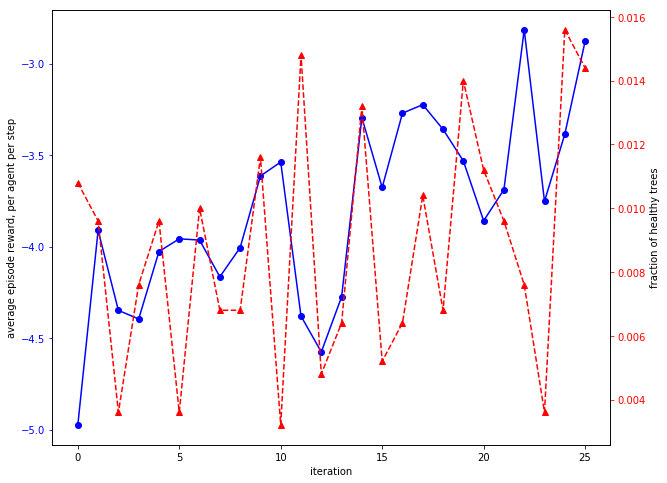

In [82]:
fig,ax1 = plt.subplots()
t = len(plot_avg_rew)
plt.plot(range(t),plot_avg_rew,'b-o')
ax1.set_xlabel('iteration')
ax1.set_ylabel('average episode reward, per agent per step')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
plt.plot(range(t),plot_frac_burn,'r--^')
ax2.set_ylabel('fraction of healthy trees')
ax2.tick_params('y', colors='r')

In [21]:
Q

Variable containing:
-0.1491
 0.0462
 0.2771
 0.2127
 0.0667
 0.0676
 0.0786
-0.0164
-0.4556
[torch.cuda.FloatTensor of size 9x1 (GPU 0)]

In [ ]:
plt.figure()
plt.xlim([0,grid_size+1])
plt.ylim([0,grid_size+1])
for i in range(grid_size):
    for j in range(grid_size):
        x = col_to_x(j)
        y = row_to_y(grid_size,i)
        if sim.state[i,j] == 1:
            plt.plot(x,y,"rs",alpha=0.6)
        elif sim.state[i,j] == 2:
            plt.plot(x,y,"ks",alpha=0.6)

In [21]:
epsilon

0.2279349999984569

In [65]:
-(eps_init - eps_finl) / anneal_range

-9e-05

Save network and optimizer checkpoint

In [ ]:
state = {
    'state_dict': model.state_dict(),
    'target_dict': target.state_dict(),
    'optimizer': optimizer.state_dict(),
    'replay': D,
    'epsilon': epsilon,
    'plot_reward': plot_avg_rew,
    'plot_frac_hlthy': plot_frac_burn,
}
#filename = 'checkpoint.pth.tar'
filename = 'checkpoint-' + time.strftime('%d-%b-%Y-%H:%M') + '.pth.tar'
torch.save(state, filename)

test loading of netork and optimizer checkpoint

In [48]:
checkpoint = torch.load(filename)
test_model = eelfff_net(act_seq=other_act_seq, img_dim=img_dim).type(dtype)
test_model.load_state_dict(checkpoint['state_dict'])
test_target = eelfff_net(act_seq=other_act_seq, img_dim=img_dim).type(dtype)
test_target.load_state_dict(checkpoint['target_dict'])
test_optim = optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-4)
test_optim.load_state_dict(checkpoint['optimizer'])
test_D = checkpoint['replay']
test_epsilon = checkpoint['epsilon']
test_plot_reward = checkpoint['plot_reward']
test_plot_frac_hlthy = checkpoint['plot_frac_hlthy'] 

In [46]:
'checkpoint-' + time.strftime('%d-%b-%Y-%H:%M') + '.pth.tar'

'checkpoint-01-Aug-2017-17:39.pth.tar'

## Test the network in simulation

In [38]:
num_agents = [6]
seeds = [1]

average reward: 6.08
episode stats: [2474   24    2], 0.989600
1.42s = 0.02m elapsed


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


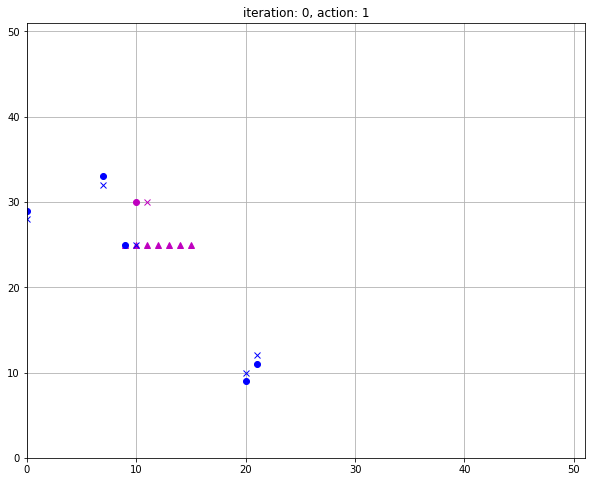

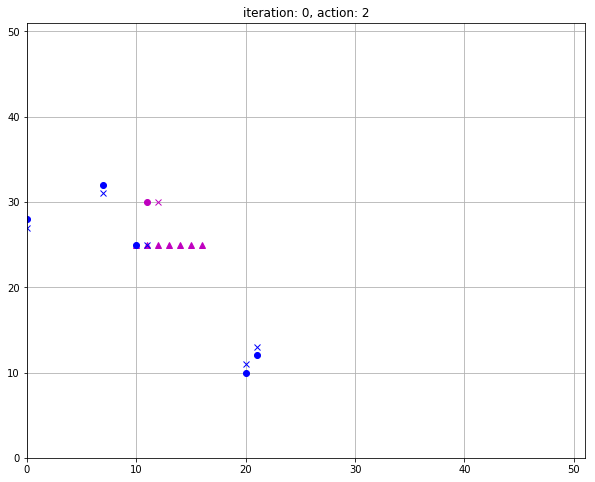

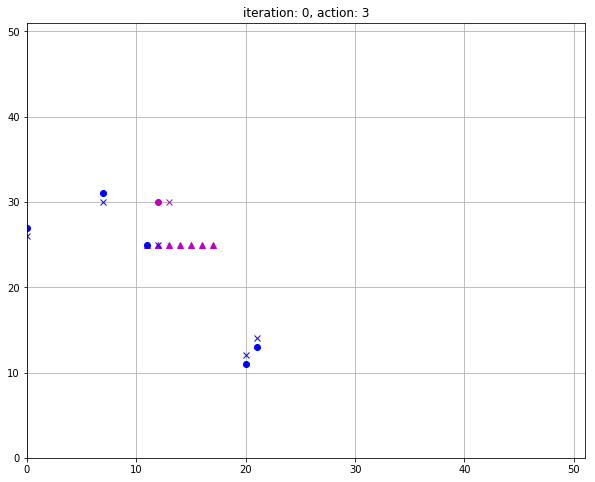

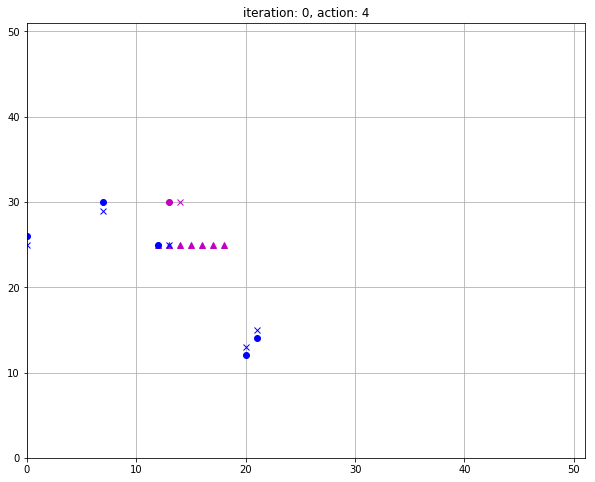

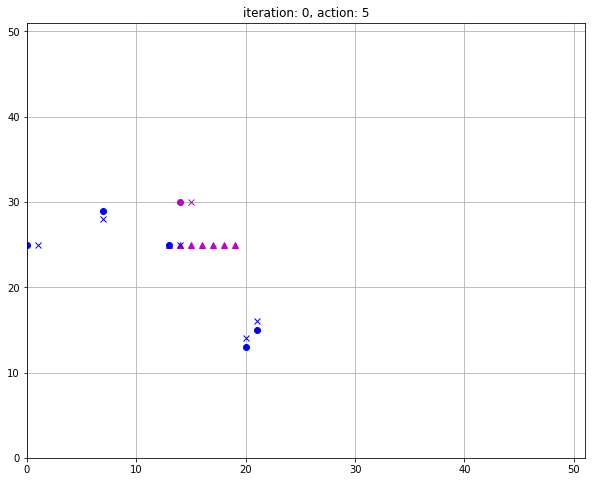

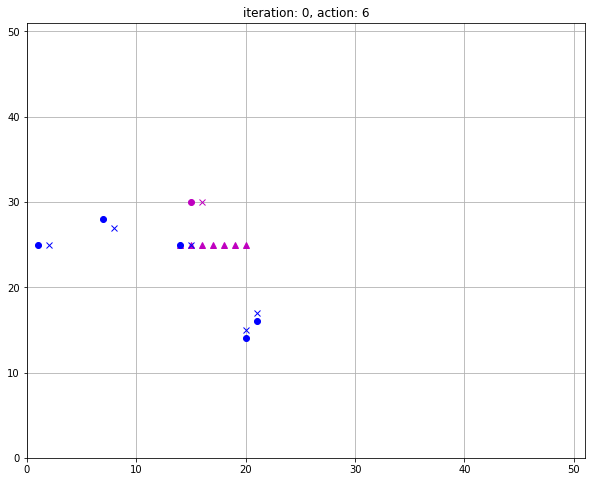

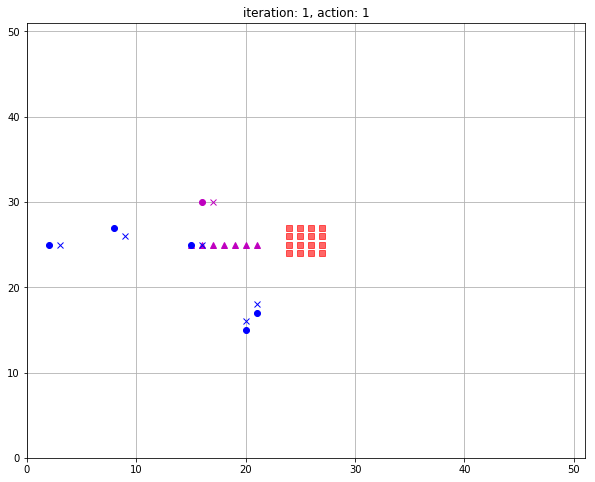

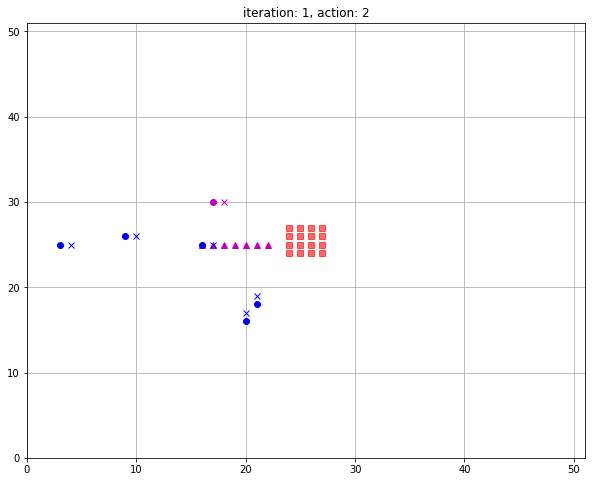

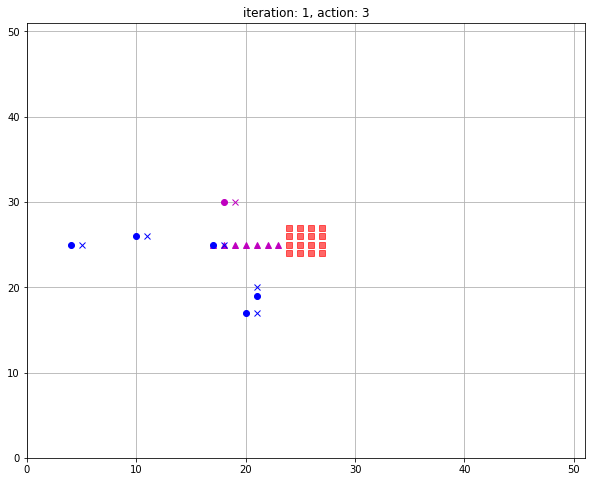

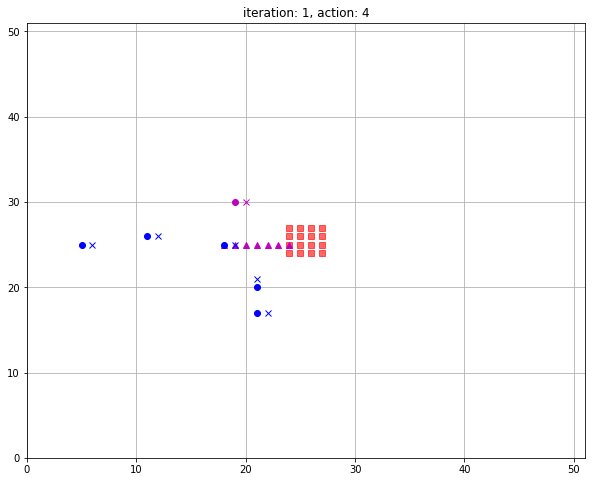

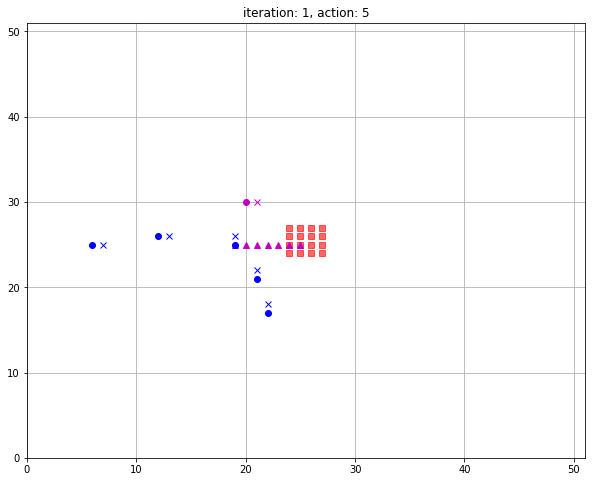

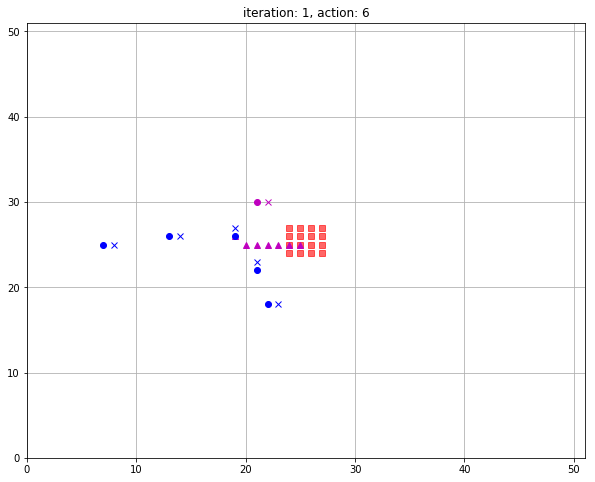

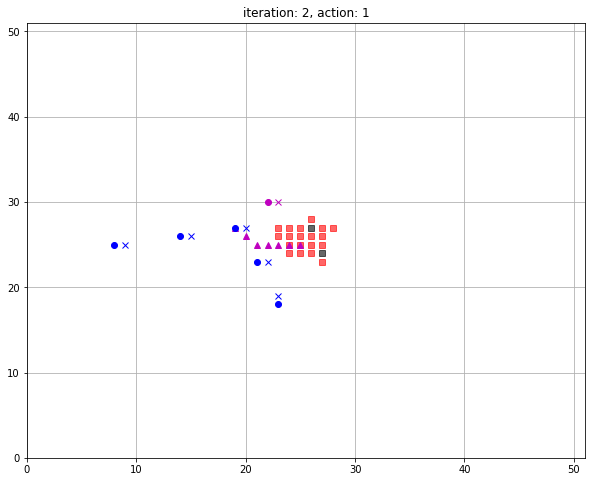

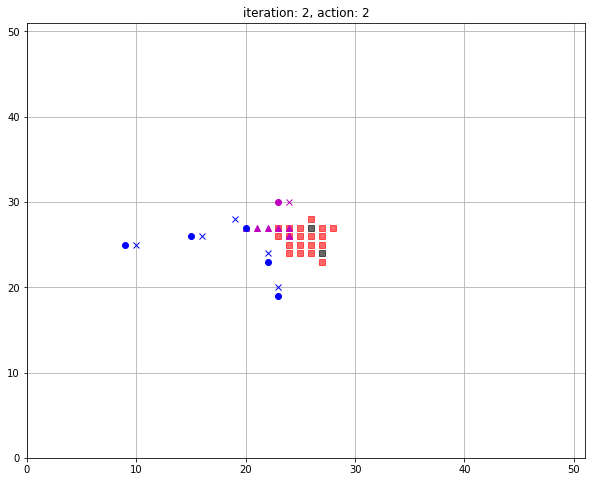

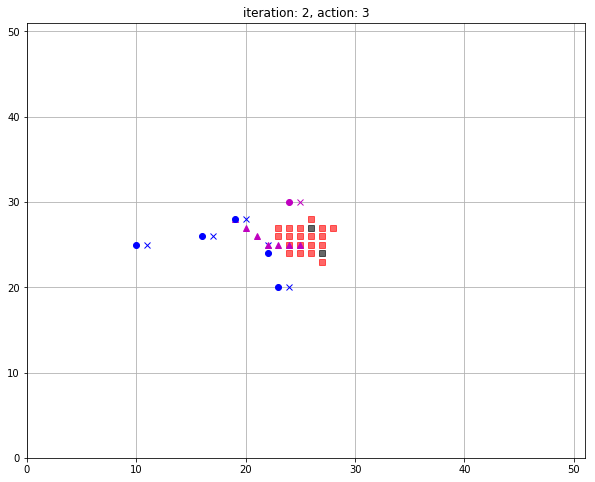

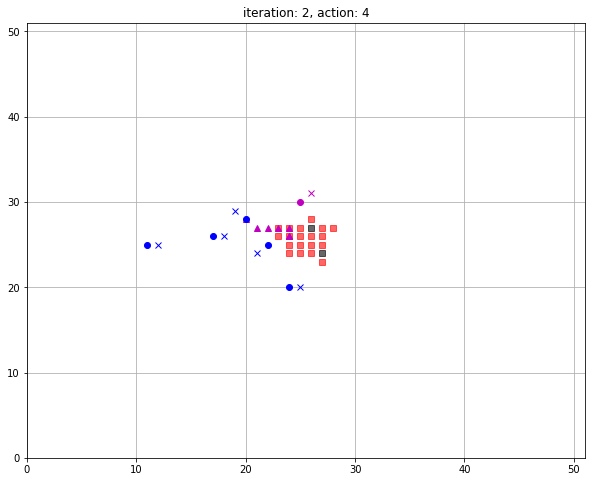

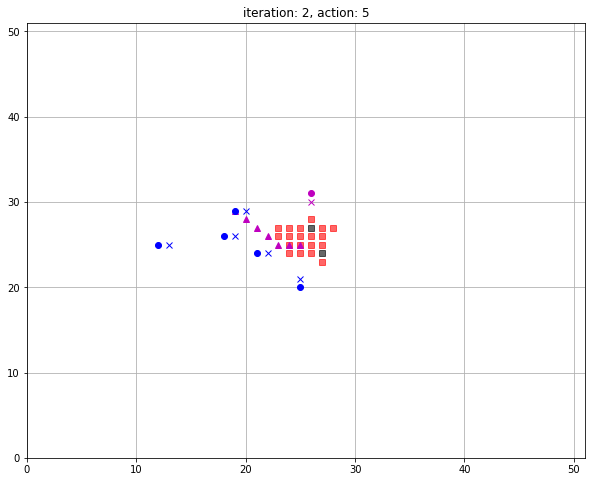

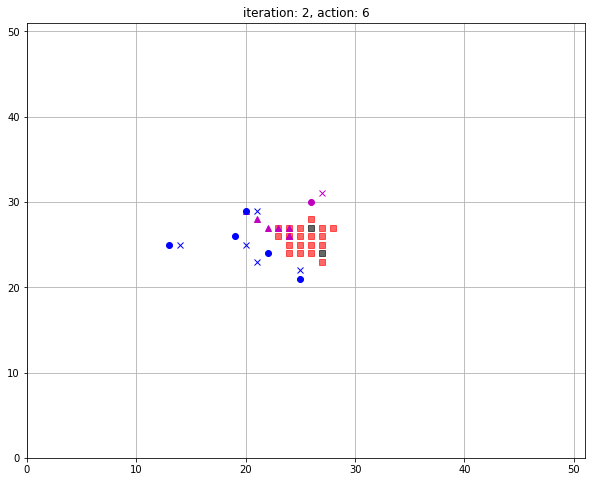

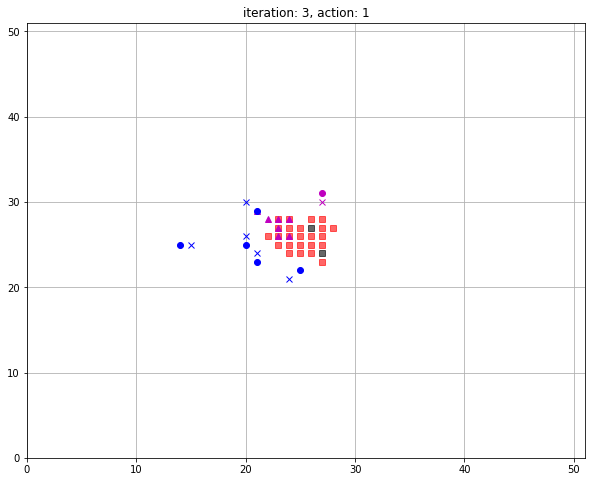

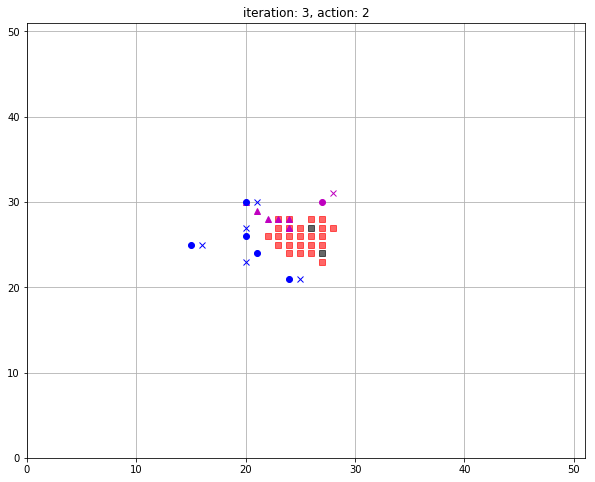

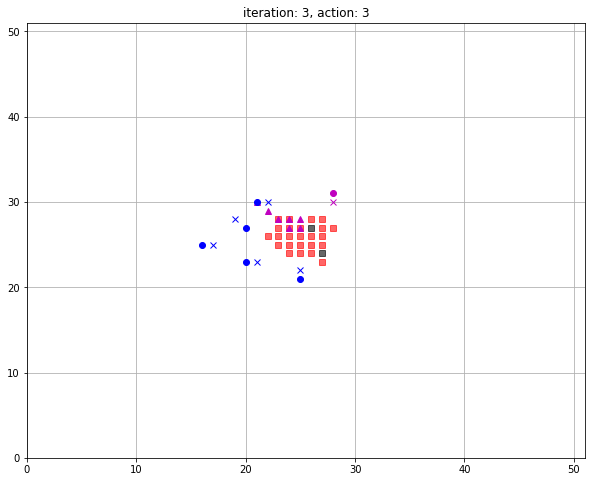

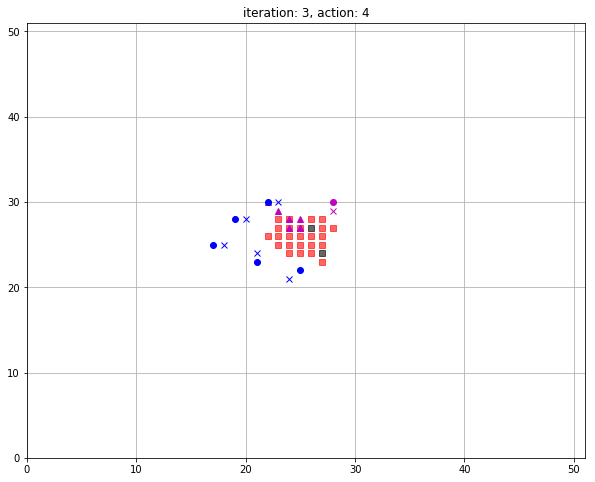

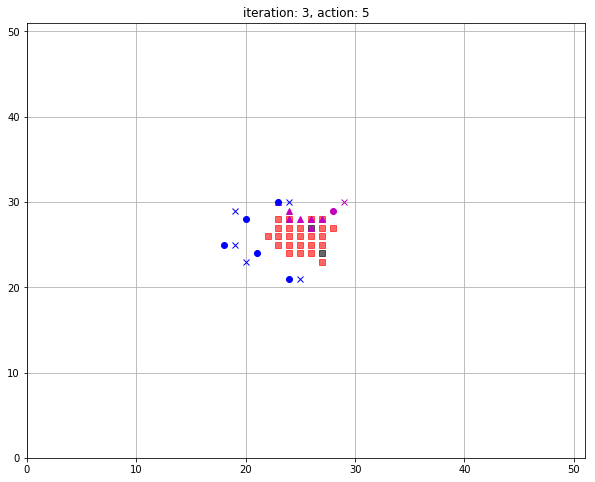

In [68]:
plt.close("all")
tic = time.clock()
# run simulator many times
for s in seeds:
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    
    # initialize agent positions
    n = np.squeeze(np.random.choice(num_agents, 1))
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)
    
    ep_rew = 0
    
    control = []
    repeat_cntr = 1
        
    # run to termination
    #while not sim.end:
    for _ in range(23):
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_cntr))
        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6)
        
        #control = []
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        agent_data = {}
        #print(agent_pos)
        
        # generate control for each agent
        for k in range(n):
            # generate image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

            # find nearest neighbor and their trajectory, and save it
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            min_idx = min(dists)[1]
            other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, other_act_seq, other_img_st, other_hasfire, control)
            
            # generate actions using network
            pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var

            img_var = Variable(torch.from_numpy(img)).type(dtype)
            other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            hasfire_var = Variable(hasfire*torch.ones(1)).type(dtype)

            #img_var = empty_img_var
            #other_traj_var = empty_traj_var
            Q = model(img_var, other_traj_var, pos_cen_var, hasfire_var)[0].data.cpu().numpy()
            #print(Q)
            #print("range of Q values: %f to %f" %(np.amin(Q),np.amax(Q)))
            actions = np.argmax(Q,axis=0)
            traj = actions_to_trajectory(agent_pos[k,:], actions)
                            
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))
            #if len(control) > 0:
            #    print('control is non-empty')
            
            if k == 1:
                plt.plot(traj[0][0],traj[0][1],"mo")
                plt.plot(traj[-1][0],traj[-1][1],"mx")
                for (x,y) in other_traj:
                    plt.plot(x,y,"m^")
            else:
                plt.plot(traj[0][0],traj[0][1],"bo")
                plt.plot(traj[-1][0],traj[-1][1],"bx")
            #for (x,y) in traj:
            #    plt.plot(x,y,"bo")
                
            #for (x,y) in other_traj:
            #    plt.plot(x,y,"b^")
            
            # calculate and store reward for agent
            #reward = eelfff_reward([sim.state], [traj], [hasfire], [other_traj])
            reward = eelfff_reward(sim.state, traj, other_traj, control)
            #print(reward)
            ep_rew += reward
                        
            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
            
        # remove duplicates from control sequence
        control = list(set(control))
        #if control:
        #    print('control is not empty')
        #    print(control)
        #    5/0
        
        # step simulator
        #sim.step(control, dbeta=dp)
        if repeat_cntr % act_repeat == 0:
            #print(control)
            sim.step(control, dbeta=dp)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1
        
        # update agent position
        agent_pos = new_agent_pos
            
    print("average reward: %0.2f" %(ep_rew/(n*sim.iter)))
    print("episode stats: %s, %f" %(sim.stats,sim.stats[0]/np.sum(sim.stats)))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

In [ ]:
Q

In [ ]:
agent_pos

In [ ]:
spawn_loc
perturbs

In [ ]:
hasfire_var

In [ ]:
Q

In [ ]:
D[15]

In [ ]:
exp

In [ ]:
plt.close("all")

In [ ]:
other_traj_var

In [ ]:
Variable(torch.from_numpy(agent_pos[0])).type(dtype) - cen_var

In [ ]:
next_other_traj_var

In [ ]:
torch.zeros(10,10)

In [ ]:
list(model.parameters())

In [ ]:
agent_pos

In [ ]:
traj[0]

In [ ]:
agent_data

In [ ]:
traj

In [ ]:
other_traj

In [ ]:
type(exp[5][0][1])

In [ ]:
D[100]

In [ ]:
type(np.asarray(other_traj)[0][0])

In [ ]:
type(np.asarray(exp[5])[0][0])

In [ ]:
type(exp[5][0][1])

In [ ]:
type(traj[0][0])

In [ ]:
torch.cuda.FloatTensor(traj)

In [ ]:
np.asarray(exp[5])

In [ ]:
np.asarray(other_traj).reshape((-1,))

In [ ]:
other_traj

In [ ]:
agent_pos.astype(np.int8)

In [ ]:
control

In [ ]:
exp[2]

In [ ]:
Q[torch.from_numpy(exp[2]).type(torch.cuda.LongTensor)]

In [ ]:
Q[torch.from_numpy(exp[2]).type(torch.cuda.LongTensor)].diag()

In [ ]:
torch.randn(2)

In [ ]:
traj

In [ ]:
np.linalg.norm([traj[0][0]-traj[1][0], traj[0][1]-traj[1][1]],1)

In [ ]:
center